In [ ]:
# !pip install dask[dataframe]
# !sudo apt-get install graphviz graphviz-dev
# !sudo apt-get install build-essential
# !pip install pygraphviz
# !pip install dowhy==0.8
# !pip install econml

In [2]:
from copy import deepcopy

import numpy as np
import pandas as pd
from scipy import stats

from sklearn.metrics import mean_absolute_percentage_error

import dowhy
from dowhy import CausalModel

from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

from lightgbm import LGBMRegressor, LGBMClassifier

import networkx as nx

from tqdm import tqdm

import matplotlib.pyplot as plt

import graphviz
import warnings

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

In [3]:
COLORS = [
    '#00B0F0',
    '#FF0000',
    '#B0F000'
]

def plot_effect(effect_true, effect_pred, figsize=(10, 7), ylim=(5000, 22000)):
    plt.figure(figsize=figsize)
    plt.scatter(effect_true, effect_pred, color=COLORS[0])
    plt.plot(np.sort(effect_true), np.sort(effect_true), color=COLORS[1], alpha=.7, label='Perfect model')
    plt.xlabel('$True\ effect$', fontsize=14, alpha=.5)
    plt.ylabel('$Predicted\ effect$', fontsize=14, alpha=.5)
    plt.ylim(ylim[0], ylim[1])
    plt.legend()
    plt.show()

# Read Data

In [4]:
# Train set
earnings_interaction_train = pd.read_csv('./data/ml_earnings_interaction_train.csv')

# Test set
earnings_interaction_test = pd.read_csv('./data/ml_earnings_interaction_test.csv')

In [5]:
earnings_interaction_train.shape, earnings_interaction_test.shape

((5000, 4), (100, 4))

In [6]:
# Train
earnings_interaction_train.head()

,age,python_proficiency,took_a_course,earnings
0,23,0.632318,True,139267.0
1,20,0.602551,False,115569.0
2,21,0.518225,False,119142.0
3,25,0.945161,False,130291.0
4,30,0.636251,True,164209.0


In [7]:
# Test
earnings_interaction_test.head()

,age,python_proficiency,took_a_course,true_effect
0,30,0.223877,True,11120.0
1,23,0.394152,True,11970.0
2,37,0.214638,True,11073.0
3,21,0.869069,True,14345.0
4,41,0.833934,True,14169.0


# Define the graph

In [8]:
nodes = ['took_a_course', 'python_proficiency', 'earnings', 'age']
edges = [
    ('took_a_course', 'earnings'),
    ('age', 'took_a_course'),
    ('age', 'earnings'),
    ('python_proficiency', 'earnings')
]

# Generate the GML graph
gml_string = 'graph [directed 1\n'

for node in nodes:
    gml_string += f'\tnode [id "{node}" label "{node}"]\n'

for edge in edges:
    gml_string += f'\tedge [source "{edge[0]}" target "{edge[1]}"]\n'

gml_string += ']'

In [9]:
# Instantiate the CausalModel
model = CausalModel(
    data=earnings_interaction_train,
    treatment='took_a_course',
    outcome='earnings',
    effect_modifiers='python_proficiency',
    graph=gml_string
)

In [10]:
model.view_model()

In [11]:
# Get the estimand
estimand = model.identify_effect()

print(estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                         
────────────────(E[earnings|age])
d[took_a_course]                 
Estimand assumption 1, Unconfoundedness: If U→{took_a_course} and U→earnings then P(earnings|took_a_course,age,U) = P(earnings|took_a_course,age)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



# Estimate Effect | S-Learner

In [ ]:
# Get estimate (S-Learner)
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.metalearners.SLearner',
    target_units='ate',
    method_params={
        'init_params': {
            'overall_model': LGBMRegressor(n_estimators=500, max_depth=10)
        },
        'fit_params': {}
    })

In [13]:
# cate estimates
estimate.cate_estimates

array([12656.36520543, 14362.76895365, 11965.20495174, ...,
       13812.20928872, 12930.34061036, 13863.00226379])

In [14]:
# cate estimates mean
estimate.cate_estimates.mean()

12547.068205674783

### Refute

In [ ]:
refutation = model.refute_estimate(
    estimand=estimand,
    estimate=estimate,
    method_name='random_common_cause'
)

In [16]:
print(refutation)

Refute: Add a random common cause
Estimated effect:12547.068205674783
New effect:12550.070868505223
p value:0.94



In [ ]:
refutation = model.refute_estimate(
    estimand=estimand,
    estimate=estimate,
    method_name='placebo_treatment_refuter')

In [18]:
print(refutation)

Refute: Use a Placebo Treatment
Estimated effect:12547.068205674783
New effect:-3.608076109292814
p value:0.96



### Test Data Prediction

In [19]:
# Compute predictions
effect_pred = model.causal_estimator.effect(earnings_interaction_test.drop(['true_effect', 'took_a_course'], axis=1))

# Get the true effect
effect_true = earnings_interaction_test['true_effect'].values

In [20]:
# Compute the error
mean_absolute_percentage_error(effect_true, effect_pred)

0.050273209257800315

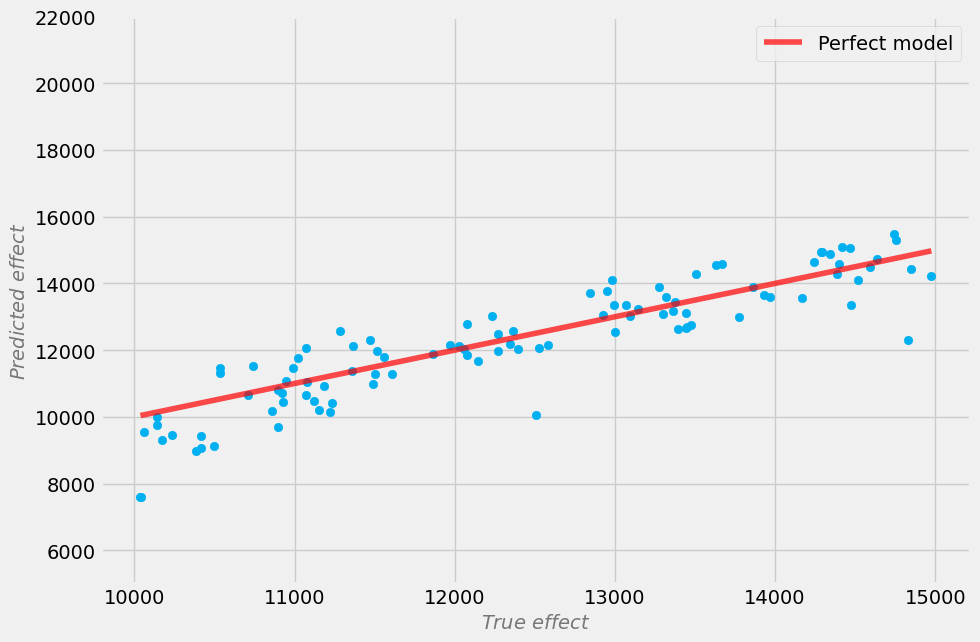

In [21]:
plot_effect(
    effect_true=effect_true,
    effect_pred=effect_pred,
)

# T Learner

In [ ]:
# Get estimate (T-Learner)
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.metalearners.TLearner',
    target_units='ate',
    method_params={
        'init_params': {
            'models': [
                LGBMRegressor(n_estimators=200, max_depth=10),
                LGBMRegressor(n_estimators=200, max_depth=10)
            ]
        },
        'fit_params': {}
    })

In [23]:
estimate.cate_estimates.mean()

12512.558912135146

### Test Data Prediction

In [24]:
# Compute predictions
effect_pred = model.causal_estimator.effect(earnings_interaction_test.drop(['true_effect', 'took_a_course'], axis=1))

# Get the true effect
effect_true = earnings_interaction_test['true_effect'].values

In [25]:
# Compute the error
mean_absolute_percentage_error(effect_true, effect_pred)

0.0813365927834967

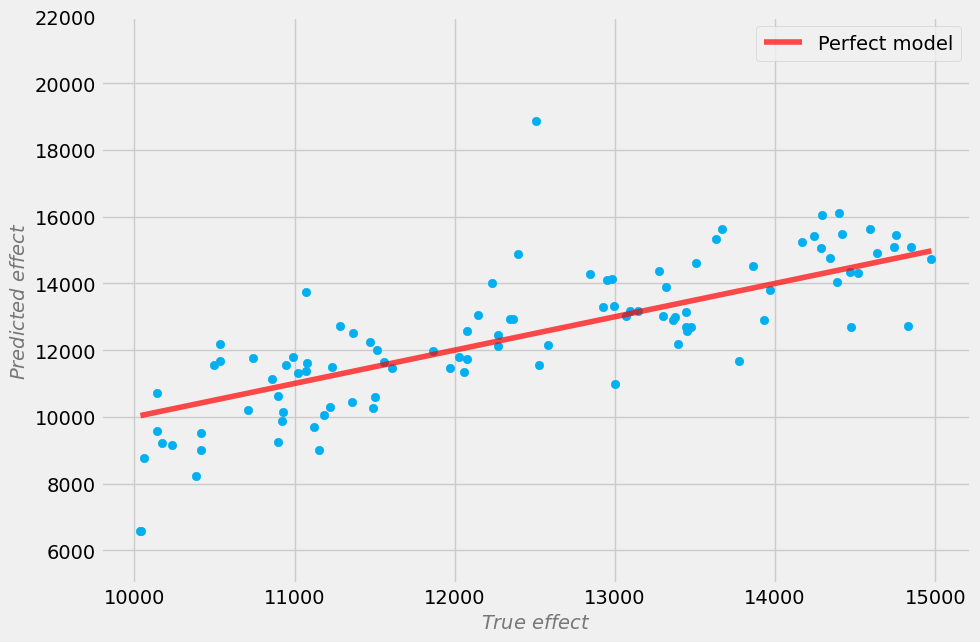

In [26]:
plot_effect(
    effect_true=effect_true,
    effect_pred=effect_pred,
)

# X-Learner

## Steps for `XLearner`

### Split Data into Treatment and Control Groups
Separate your dataset into two groups: one for the treated units and one for the control units.

### Train Initial Models
Train two models: one on the control group to predict the outcome for the control units, and another on the treatment group to predict the outcome for the treated units.
These models are used to estimate the potential outcomes for both treated and control units.

### Estimate Potential Outcomes
Use the trained models to predict the potential outcomes for all units in the dataset.
For each unit, predict the outcome if it were treated and if it were not treated.

### Calculate Pseudo-Outcomes
Calculate the pseudo-outcomes for the control and treatment groups.
- For the control group, the pseudo-outcome is the difference between the observed outcome and the predicted outcome if treated.
- For the treatment group, the pseudo-outcome is the difference between the observed outcome and the predicted outcome if not treated.

### Train CATE Models
Train two new models to predict the Conditional Average Treatment Effect (CATE) using the pseudo-outcomes.
- One model is trained on the control group pseudo-outcomes.
- The other model is trained on the treatment group pseudo-outcomes.

### Estimate CATE
Use the trained CATE models to estimate the treatment effect for each unit in the dataset.
Combine the estimates from the two CATE models to get the final treatment effect estimate for each unit.

### Aggregate Treatment Effects
Aggregate the individual treatment effects to get the overall Average Treatment Effect (ATE) or other relevant metrics.


In [ ]:
# Get estimate (X-Learner)
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.metalearners.XLearner',
    target_units='ate',
    method_params={
        'init_params': {
            'models': [
                LGBMRegressor(n_estimators=50, max_depth=10),
                LGBMRegressor(n_estimators=50, max_depth=10)
            ],
            'cate_models': [
                LGBMRegressor(n_estimators=50, max_depth=10),
                LGBMRegressor(n_estimators=50, max_depth=10)
            ]
        },
        'fit_params': {},
    })

In [28]:
estimate.cate_estimates.mean()

12564.92049684473

### Predict on Test Data

In [29]:
# Compute predictions
effect_pred = model.causal_estimator.effect(earnings_interaction_test.drop(['true_effect', 'took_a_course'], axis=1))

# Get the true effect
effect_true = earnings_interaction_test['true_effect'].values

In [30]:
# Compute the error
mean_absolute_percentage_error(effect_true, effect_pred)

0.03632496167563179

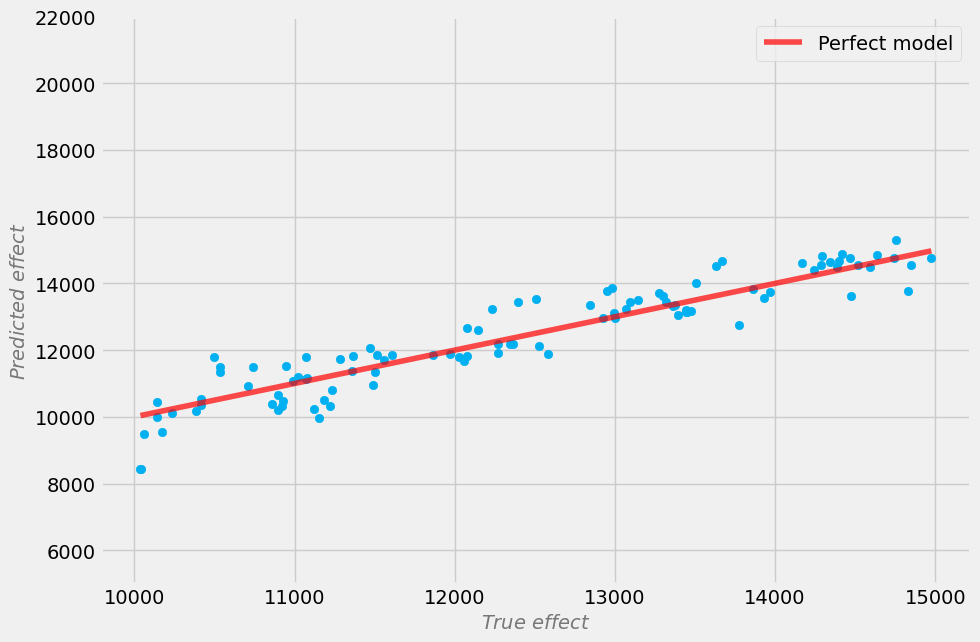

In [31]:
plot_effect(
    effect_true=effect_true,
    effect_pred=effect_pred,
)

# Doubly Robust Method

**Doubly Robust Method**<br>
The Doubly Robust Method is a statistical technique used in causal inference to estimate the effect of a treatment or exposure on an outcome. It combines two models: one for the outcome and one for the treatment (often using propensity scores). The key advantage of this method is that it provides unbiased estimates if either model is correctly specified, not necessarily both.

**Overview**<br>
`Outcome Model`: This model predicts the outcome based on observed data.<br>
`Treatment Model`: This model estimates the probability of receiving the treatment (propensity score).<br>
By combining these two models, the Doubly Robust Method ensures that even if one model is misspecified, the overall estimate remains unbiased.

In [ ]:
# Get estimate (Doubly robust)
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.dr.LinearDRLearner',
    target_units='ate',
    method_params={
        'init_params': {
            'model_propensity': LogisticRegression(),
            'model_regression': LGBMRegressor(n_estimators=1000, max_depth=10)
        },
        'fit_params': {}
    })

In [33]:
estimate.cate_estimates.mean()

12639.869418538954

In [34]:
# Compute predictions
effect_pred = model.causal_estimator.effect(earnings_interaction_test.drop(['true_effect', 'took_a_course'], axis=1))

# Get the true effect
effect_true = earnings_interaction_test['true_effect'].values

In [35]:
# Compute the error
mean_absolute_percentage_error(effect_true, effect_pred)

0.010618528666447462

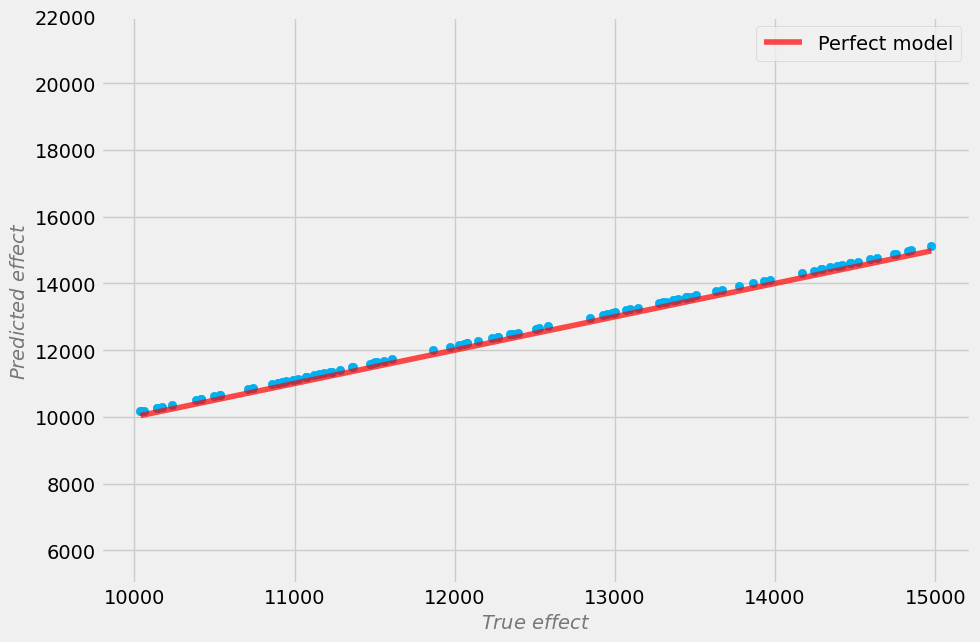

In [36]:
plot_effect(
    effect_true=effect_true,
    effect_pred=effect_pred,
)

# Non-linear DR

In [ ]:
# Get estimate (Doubly robust)
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.dr.DRLearner',
    target_units='ate',
    method_params={
        'init_params': {
            'model_propensity': LogisticRegression(),
            'model_regression': LGBMRegressor(n_estimators=1000, max_depth=10),
            'model_final': LGBMRegressor(n_estimators=500, max_depth=10),
        },
        'fit_params': {}
    })

In [38]:
# Compute predictions
effect_pred = model.causal_estimator.effect(earnings_interaction_test.drop(['true_effect', 'took_a_course'], axis=1))

# Get the true effect
effect_true = earnings_interaction_test['true_effect'].values

In [39]:
# Compute the error
mean_absolute_percentage_error(effect_true, effect_pred)

0.07251137952124423

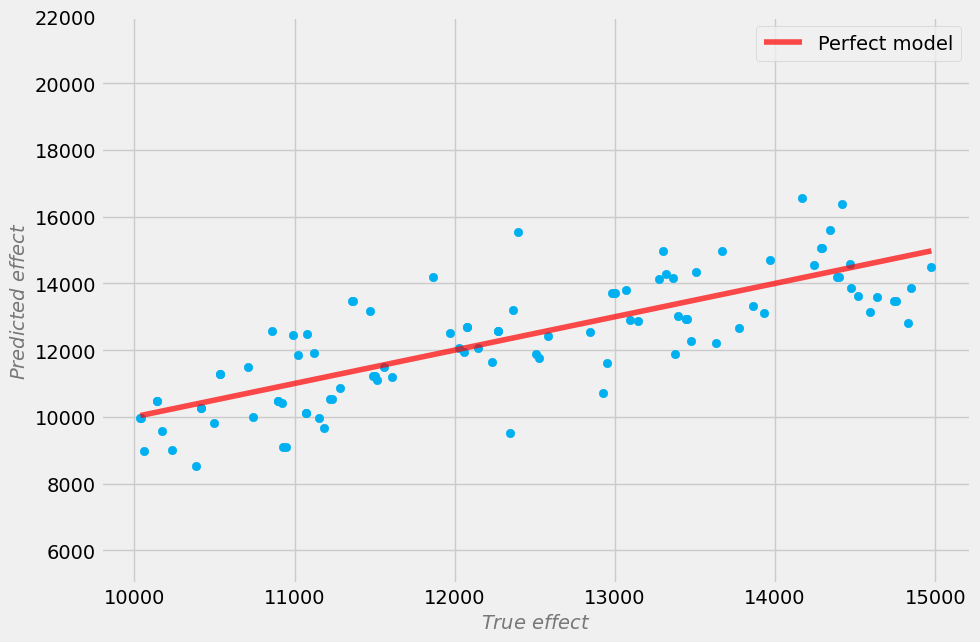

In [40]:
plot_effect(
    effect_true=effect_true,
    effect_pred=effect_pred,
)

# Double Machine Learning
## Steps of Double Machine Learning (DML)

### 1. Split the Data
- Randomly divide the dataset into `K` partitions (e.g., 5 partitions: \( D_1, D_2, D_3, D_4, D_5 \)).

### 2. Train and Estimate on Different Partitions
- In each round, **train the models** on `K-1` partitions and **estimate** (make predictions) on the remaining partition.
  
  Example for 5 partitions:
  - **Round 1**: Train on \( D_2, D_3, D_4, D_5 \), estimate on \( D_1 \).
  - **Round 2**: Train on \( D_1, D_3, D_4, D_5 \), estimate on \( D_2 \).
  - Continue this for all partitions.

### 3. Residualize the Outcome and Treatment
- After each round, calculate residuals:
- **Residual for the outcome**: $ \tilde{Y} = Y - \hat{g}(X, D) $ (actual outcome minus predicted outcome, controlling for both covariates $ X $ and treatment $ D $).
- **Residual for the treatment**: $ \tilde{D} = D - \hat{m}(X) $ (actual treatment minus predicted treatment based on covariates $ X $ only).


### 4. Estimate Treatment Effect
- Regress the residual outcome \( \tilde{Y} \) on the residual treatment \( \tilde{D} \) to estimate the treatment effect \( \theta \).

### 5. Average the Estimates
- Once cross-fitting is done across all `K` partitions, **average the treatment effect estimates** from each round to get the final unbiased estimate.

### Key Concepts:
- **Cross-fitting** ensures models are trained on one partition and estimated on a different one to prevent overfitting.
- **Residualization** removes the influence of confounding variables, allowing for a more accurate treatment effect estimate.


In [ ]:
# Get estimate (DML)
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.dml.LinearDML',
    target_units='ate',
    method_params={
        'init_params': {
            'model_y': LGBMRegressor(n_estimators=500, max_depth=10),
            'model_t': LogisticRegression(),
            'discrete_treatment': True
        },
        'fit_params': {}
    })

In [42]:
estimate.cate_estimates.mean()

12540.199528029825

### Predict on Test Data

In [43]:
# Compute predictions
effect_pred = model.causal_estimator.effect(earnings_interaction_test.drop(['true_effect', 'took_a_course'], axis=1))

# Get the true effect
effect_true = earnings_interaction_test['true_effect'].values

In [44]:
# Compute the error
mean_absolute_percentage_error(effect_true, effect_pred)

0.002854246005787978

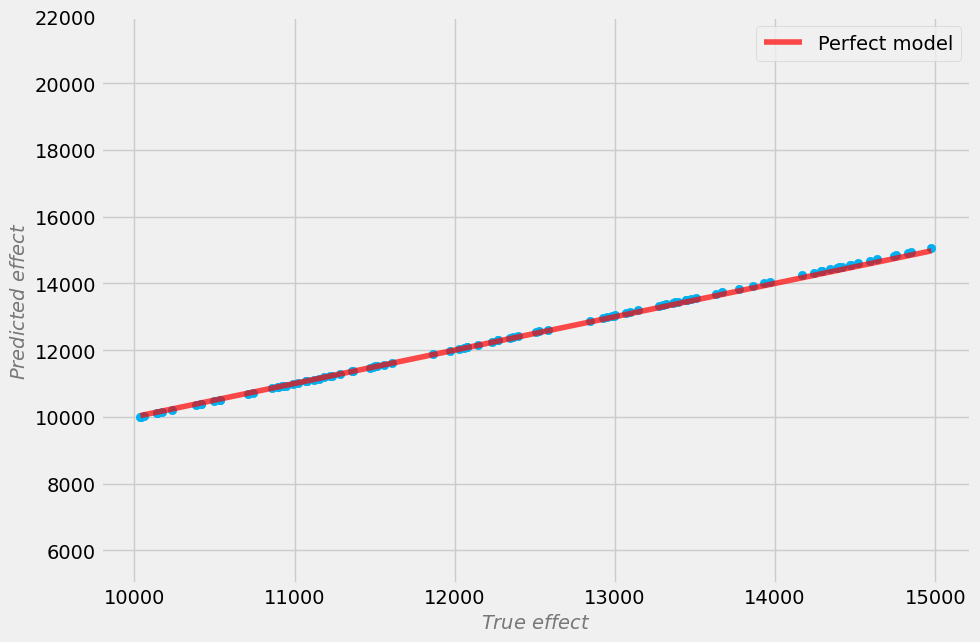

In [45]:
plot_effect(
    effect_true=effect_true,
    effect_pred=effect_pred,
)

## DML with more folds

In [ ]:
# Estimate the effect
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.dml.LinearDML',
    target_units='ate',
    method_params={
        'init_params': {
            'model_y': LGBMRegressor(n_estimators=50, max_depth=10),
            'model_t': LogisticRegression(),
            'discrete_treatment': True,
            'cv': 4
        },
        'fit_params': {
        }
    })

In [47]:
estimate.cate_estimates.mean()

12608.914806658162

In [48]:
# Compute predictions
effect_pred = model.causal_estimator.effect(earnings_interaction_test.drop(['true_effect', 'took_a_course'], axis=1))

# Get the true effect
effect_true = earnings_interaction_test['true_effect'].values

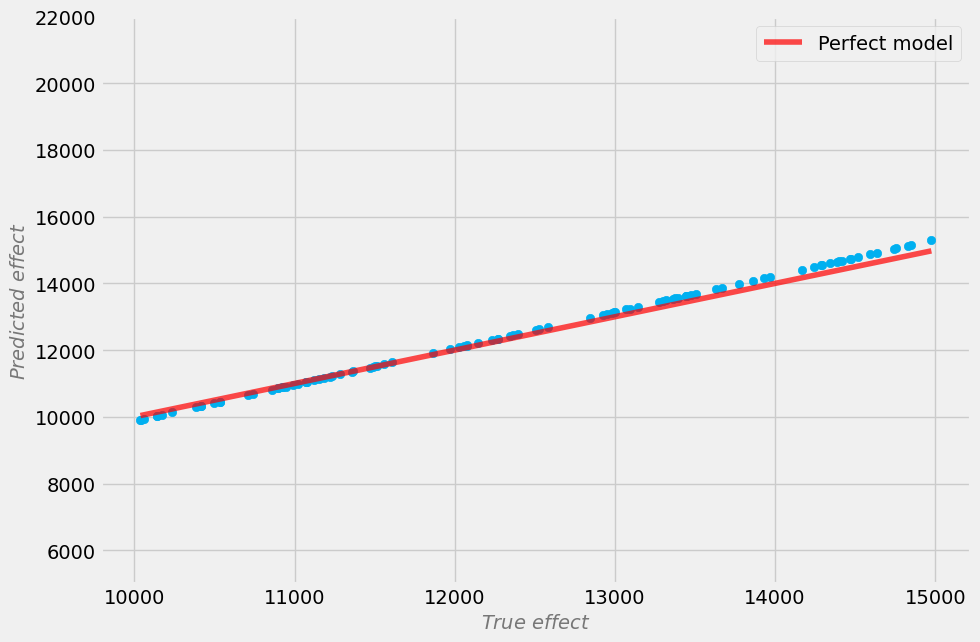

In [49]:
plot_effect(
    effect_true=effect_true,
    effect_pred=effect_pred,
)

### DML with cross-validation

In [50]:
# Define wrapped CV models
model_y = GridSearchCV(
    estimator=LGBMRegressor(),
    param_grid={
        'max_depth': [3, 10, 20, 100],
        'n_estimators': [10, 50, 100]
    }, cv=10, n_jobs=-1, scoring='neg_mean_squared_error'
)

model_t = GridSearchCV(
    estimator=LGBMClassifier(),
    param_grid={
        'max_depth': [3, 10, 20, 100],
        'n_estimators': [10, 50, 100]
    }, cv=10, n_jobs=-1, scoring='accuracy'
)

In [ ]:
# Estimate the effect
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.dml.LinearDML',
    target_units='ate',
    method_params={
        'init_params': {
            'model_y': model_y,
            'model_t': model_t,
            'discrete_treatment': True,
            'cv': 4
        },
        'fit_params': {
        }
    })

In [52]:
estimate.cate_estimates.mean()

12544.892068193487

In [53]:
# Compute predictions
effect_pred = model.causal_estimator.effect(earnings_interaction_test.drop(['true_effect', 'took_a_course'], axis=1))

# Get the true effect
effect_true = earnings_interaction_test['true_effect'].values

In [54]:
# Compute the error
mean_absolute_percentage_error(effect_true, effect_pred)

0.0030159370392151036

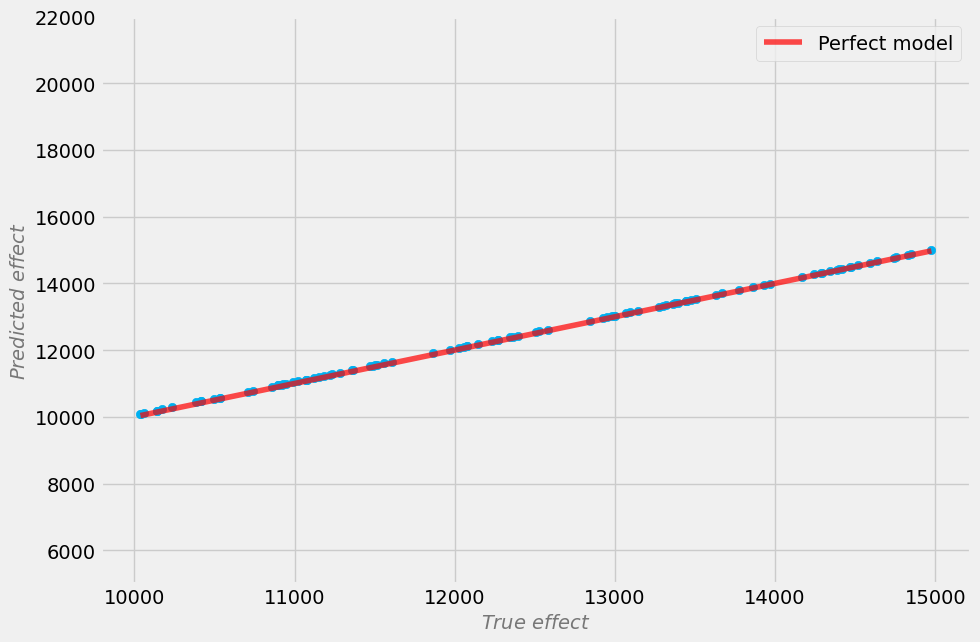

In [55]:
plot_effect(
    effect_true=effect_true,
    effect_pred=effect_pred,
)

# Causal Tress with DML

### Causal Forest (via `econml.dml.CausalForestDML`):

The `CausalForestDML` method uses decision tree-based models (in this case, **LightGBM**) to model both the outcome and the treatment assignment. The goal is to estimate the **heterogeneous treatment effect (HTE)** across different covariate subgroups.

- **`model_y`** predicts the **outcome** given covariates, while **`model_t`** predicts **treatment assignment**, both accounting for potential confounders.

The causal forest then estimates the treatment effects by regressing the residualized outcome $ \tilde{Y} $ on the residualized treatment $ \tilde{D} $.



In [ ]:
# Estimate the effect
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.dml.CausalForestDML',
    target_units='ate',
    method_params={
        'init_params': {
            'model_y': LGBMRegressor(n_estimators=50, max_depth=10),
            'model_t': LGBMClassifier(n_estimators=50, max_depth=10),
            'discrete_treatment': True,
            'cv': 4
        },
        'fit_params': {
        }
    }
)

In [57]:
estimate.cate_estimates.mean()

12414.301692976444

In [58]:
# Compute predictions
effect_pred = model.causal_estimator.effect(earnings_interaction_test.drop(['true_effect', 'took_a_course'], axis=1))

# Get the true effect
effect_true = earnings_interaction_test['true_effect'].values

In [59]:
# Compute the error
mean_absolute_percentage_error(effect_true, effect_pred)

0.04112878812220806

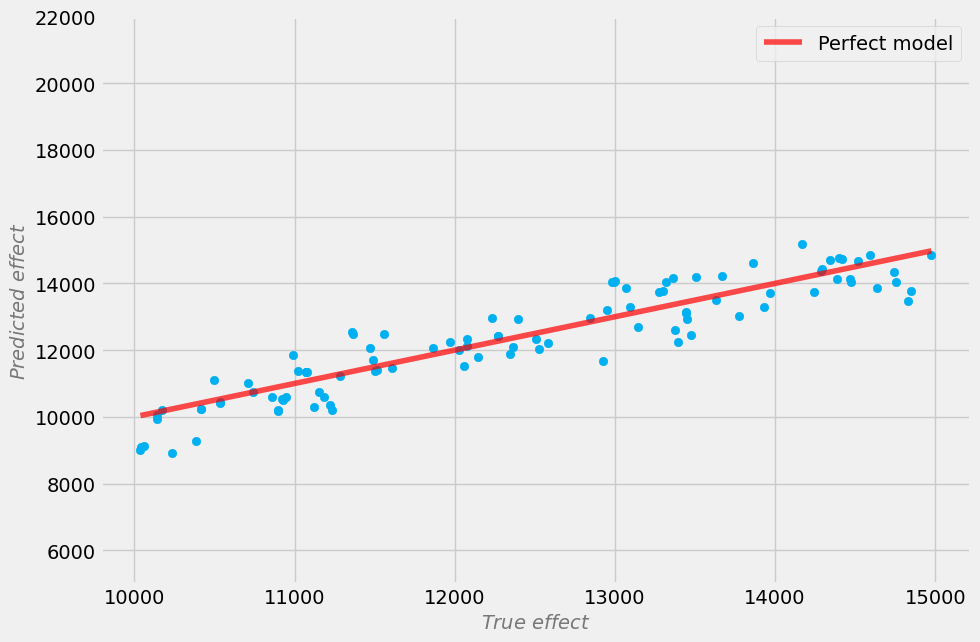

In [60]:
plot_effect(
    effect_true=effect_true,
    effect_pred=effect_pred,
)